In [1]:
import h5py
import pandas as pd
import numpy as np
#from plotnine import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
    
import statsmodels.api as sm

from scipy.stats import mode

import random
 
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

import tensorflow as tf


import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.models import load_model


Using TensorFlow backend.


In [2]:
keras.__version__
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.set_session(sess)


In [3]:
# %load "C:\\Users\\i053131\Desktop\\Epilepsie\\Dreem\\src\\utils\\error.py"

def AnalyzeError(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.subplot(1,2, 1)
    sns.countplot(x=0, data=pd.DataFrame(y_true))
    plt.ylim(0, 4000)
    plt.subplot(1,2, 2)
    sns.countplot(x=0, data=pd.DataFrame(y_pred))
    plt.ylim(0, 4000)
    fig.suptitle("Actual and predicted distribution", size =  'x-large')
    plt.show()
    
    df_ = pd.DataFrame()
    df_["Test"]= y_true
    df_["Pred"] = y_pred
    df_['error'] = df_.Test != df_.Pred
    #sns.countplot(x="Test", data=df_[df_.error])
    
    error0 = df_[(df_.error) & (df_.Test==0)].count()[0] / df_[df_.Test==0].count()[0]
    error1 = df_[(df_.error) & (df_.Test==1)].count()[0] / df_[df_.Test==1].count()[0]
    error2 = df_[(df_.error) & (df_.Test==2)].count()[0] / df_[df_.Test==2].count()[0]
    error3 = df_[(df_.error) & (df_.Test==3)].count()[0] / df_[df_.Test==3].count()[0]
    error4 = df_[(df_.error) & (df_.Test==4)].count()[0] / df_[df_.Test==4].count()[0]

    Lerror = [error0, error1, error2, error3, error4]
    sns.barplot(x=[0, 1, 2, 3, 4], y=Lerror)
    plt.title('Wrongly classified in a phase in percent of the test population for this phase')
    plt.show()

In [4]:
dataPath = "C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"

trainOutput = pd.read_csv(dataPath + "challenge_fichier_de_sortie_dentrainement_classification_en_stade_de_sommeil_a_laide_de_signaux_mesures_par_le_bandeau_dreem.csv", sep=";")
Y = trainOutput["label"]

In [5]:
filetrain= dataPath + "train.h5"
filetest= dataPath + "test.h5"
h5 = h5py.File(filetrain, "r")

In [6]:
eeg_1 = pd.DataFrame(h5['eeg_1'][:])
eeg_2 = pd.DataFrame(h5['eeg_2'][:])
eeg_3 = pd.DataFrame(h5['eeg_3'][:])
eeg_4 = pd.DataFrame(h5['eeg_4'][:])
po_ir = pd.DataFrame(h5['po_ir'][:])
po_r = pd.DataFrame(h5['po_r'][:])
accelerometer_x = pd.DataFrame(h5['accelerometer_x'][:])
accelerometer_y = pd.DataFrame(h5['accelerometer_y'][:])
accelerometer_z = pd.DataFrame(h5['accelerometer_z'][:])


In [7]:
eeg_1.shape

#step 1 eeg alone
df = pd.concat([eeg_1, eeg_2, eeg_3, eeg_4], axis=1, sort = False)
df.columns = range(15000)
#index = pd.MultiIndex.from_product([["eeg_1", "eeg_2", "eeg_3", "eeg_4"], list(range(3750))])
df["Y"] = Y

In [8]:
print(eeg_1.shape, df.shape)
df.head()
df.columns


(43830, 3750) (43830, 15001)


Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       14991, 14992, 14993, 14994, 14995, 14996, 14997, 14998, 14999,   'Y'],
      dtype='object', length=15001)

In [9]:
training, test  = train_test_split(df, test_size=0.2, random_state=42)
X = training.iloc[:,:-1]
X_train = X.values
y = training.iloc[:,-1]
y_train = to_categorical(y.values, num_classes=5)
X_test = test.iloc[:,:-1].values
y_true = test.iloc[:,-1].values
y_test = to_categorical(y_true, num_classes=5)

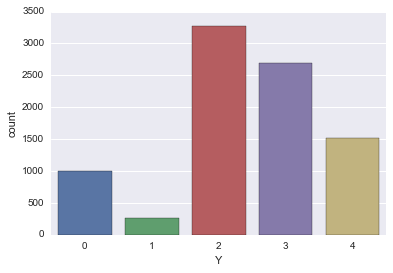

In [11]:
sns.countplot(x="Y", data=test)

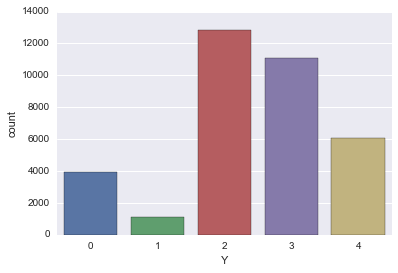

In [12]:
sns.countplot(x="Y", data=training)

In [13]:
print(X_train.shape, X_test.shape, X.shape, eeg_1.shape)
len(X_train[0, :3750])
len(X_train[0, 3750*2: 3750*3])

(35064, 15000) (8766, 15000) (35064, 15000) (43830, 3750)


3750

In [16]:

#Input to keras.layers.Conv1D should be 3-d with dimensions (nb_of_examples, timesteps, features)
#X is (nb_of_examples, timesteps)
X_train_r = np.empty(shape=(35064, 3750, 4))
X_train_r[:, :, 0]= X_train[:, :3750] #eeg_1
X_train_r[:, :, 1]= X_train[:, 3750:3750*2] #eeg_2
X_train_r[:, :, 2]= X_train[:, 3750*2:3750*3] #eeg_3
X_train_r[:, :, 3]= X_train[:, 3750*3:3750*4] #eeg_4

#X_test_r = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train_r.shape

X_test_r = np.empty(shape=(8766, 3750, 4))
X_test_r[:, :, 0]= X_test[:, :3750] #eeg_1
X_test_r[:, :, 1]= X_test[:, 3750:3750*2] #eeg_2
X_test_r[:, :, 2]= X_test[:, 3750*2:3750*3] #eeg_3
X_test_r[:, :, 3]= X_test[:, 3750*3:3750*4] #eeg_4


In [17]:
print(X_train_r[X_train_r==0], X_test_r[X_test_r==0])
X_train_r.shape[1:3]

[] []


(3750, 4)

In [18]:
#125Hz 


nb_filter1 = 5
kernel_size1 = 25

model = Sequential()
model.add(Conv1D(nb_filter=nb_filter1, kernel_size=kernel_size1, activation='relu', strides = 1, padding='valid', 
                 input_shape=X_train_r.shape[1:3]))

model.add(MaxPooling1D(25))
model.add(Conv1D(nb_filter=20, kernel_size=10, activation='relu', strides = 1, padding='valid'))
model.add(MaxPooling1D(10))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(5, activation='softmax'))

#optimizer = SGD(lr=0.0001)
#optimizer='rmsprop'
optimizer=Adam(0.0001)

model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train_r, y_train, batch_size=100, epochs=50, validation_data = (X_test_r, y_test))
score = model.evaluate(X_test_r, y_test, batch_size=100)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

C:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=25, activation="relu", strides=1, padding="valid", input_shape=(3750, 4), filters=5)`
  if __name__ == '__main__':
C:\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=10, activation="relu", strides=1, padding="valid", filters=20)`
  if sys.path[0] == '':


Train on 35064 samples, validate on 8766 samples
Epoch 1/50
35064/35064 [==============================] - 17s 479us/step - loss: 5.9009 - acc: 0.3713 - val_loss: 8.4286 - val_acc: 0.3396
Epoch 2/50
35064/35064 [==============================] - 14s 404us/step - loss: 7.8180 - acc: 0.3185 - val_loss: 7.2523 - val_acc: 0.3133
Epoch 3/50
35064/35064 [==============================] - 14s 404us/step - loss: 7.3912 - acc: 0.3224 - val_loss: 7.1466 - val_acc: 0.3296
Epoch 4/50
35064/35064 [==============================] - 14s 404us/step - loss: 7.0859 - acc: 0.3332 - val_loss: 6.1982 - val_acc: 0.2525
Epoch 5/50
34900/35064 [============================>.] - ETA: 0s - loss: 3.4634 - acc: 0.4271

KeyboardInterrupt: 

In [161]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 3726, 5)           505       
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 149, 5)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 140, 20)           1020      
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 14, 20)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 280)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 500)               140500    
_________________________________________________________________
dense_53 (Dense)             (None, 500)               250500    
__________

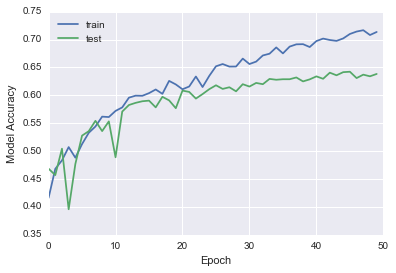

In [169]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [163]:
y_pred = pd.DataFrame(model.predict_classes(X_test_r, batch_size=128))
print("accurancy: ", accuracy_score(y_true, y_pred))
print("kappa: ", cohen_kappa_score(y_true, y_pred))

In [164]:
print("accurancy: ", accuracy_score(y_true, y_pred))
print("kappa: ", cohen_kappa_score(y_true, y_pred))

accurancy:  0.6382614647501711
kappa:  0.4883591195472702


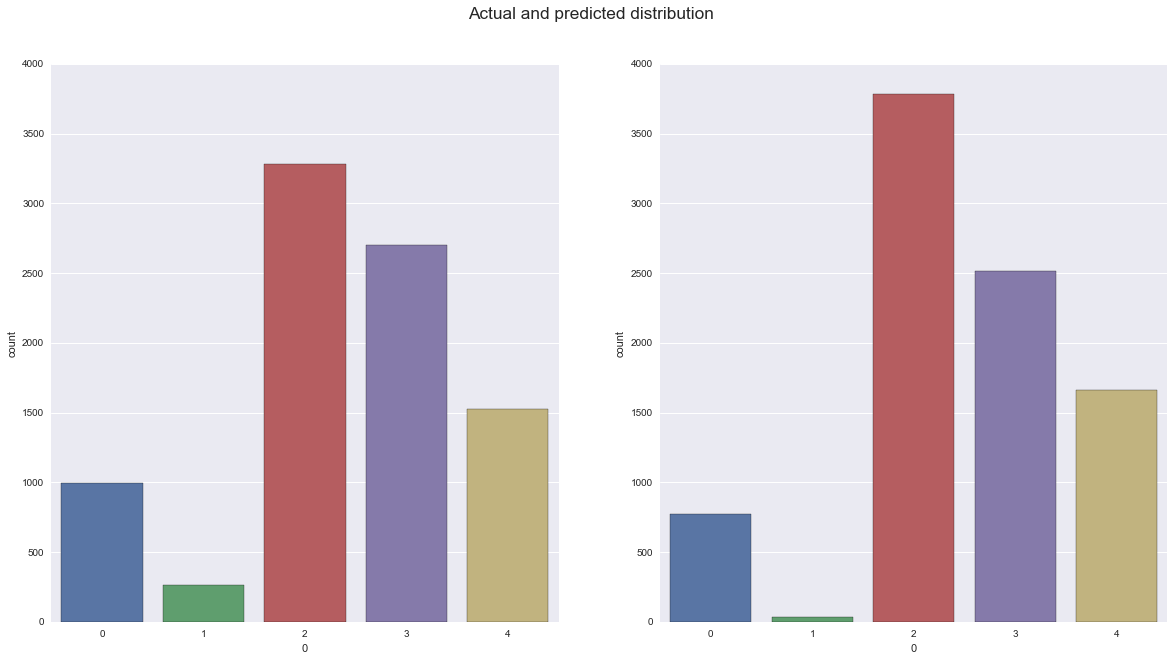

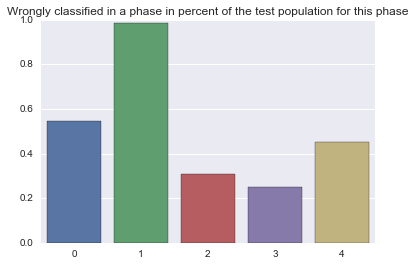

In [165]:
AnalyzeError(y_true, y_pred)

In [171]:
#125Hz 
# filtres sur 2 secondes so kernel_size =  250 (convolution windows of 2 seconds)

nb_filter1 = 20
kernel_size1 = 25

model = Sequential()
model.add(Conv1D(nb_filter=nb_filter1, kernel_size=kernel_size1, activation='relu', strides = 1, padding='valid', 
                 input_shape=X_train_r.shape[1:3]))

model.add(MaxPooling1D(25))
model.add(Conv1D(nb_filter=20, kernel_size=10, activation='relu', strides = 1, padding='valid'))
model.add(MaxPooling1D(10))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(5, activation='softmax'))

#optimizer = SGD(lr=0.0001)
#optimizer='rmsprop'
optimizer=Adam(0.0001)

model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train_r, y_train, batch_size=100, epochs=50, validation_data = (X_test_r, y_test))
score = model.evaluate(X_test_r, y_test, batch_size=100)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=25, activation="relu", strides=1, padding="valid", input_shape=(3750, 4), filters=20)`
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=10, activation="relu", strides=1, padding="valid", filters=20)`
  if sys.path[0] == '':


Train on 35064 samples, validate on 8766 samples
Epoch 1/50
35064/35064 [==============================] - 92s 3ms/step - loss: 4.6711 - acc: 0.3990 - val_loss: 3.7511 - val_acc: 0.4472
Epoch 2/50
35064/35064 [==============================] - 90s 3ms/step - loss: 3.6287 - acc: 0.4433 - val_loss: 3.5786 - val_acc: 0.4744
Epoch 3/50
35064/35064 [==============================] - 89s 3ms/step - loss: 3.1607 - acc: 0.4748 - val_loss: 3.1068 - val_acc: 0.4544
Epoch 4/50
35064/35064 [==============================] - 90s 3ms/step - loss: 2.7923 - acc: 0.4897 - val_loss: 2.7414 - val_acc: 0.5033
Epoch 5/50
35064/35064 [==============================] - 91s 3ms/step - loss: 2.5542 - acc: 0.5109 - val_loss: 2.5651 - val_acc: 0.5065
Epoch 6/50
35064/35064 [==============================] - 88s 3ms/step - loss: 2.3633 - acc: 0.5219 - val_loss: 2.5272 - val_acc: 0.4799
Epoch 7/50
35064/35064 [==============================] - 88s 2ms/step - loss: 2.3556 - acc: 0.5195 - val_loss: 2.2899 - val_acc:

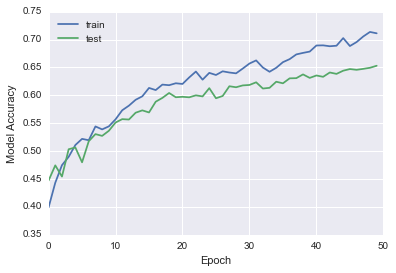

In [172]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [174]:
#125Hz 
# filtres sur 2 secondes so kernel_size =  250 (convolution windows of 2 seconds)

nb_filter1 = 5
kernel_size1 = 100

model = Sequential()
model.add(Conv1D(nb_filter=nb_filter1, kernel_size=kernel_size1, activation='relu', strides = 1, padding='valid', 
                 input_shape=X_train_r.shape[1:3]))

model.add(MaxPooling1D(25))
model.add(Conv1D(nb_filter=20, kernel_size=10, activation='relu', strides = 1, padding='valid'))
model.add(MaxPooling1D(10))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(5, activation='softmax'))

#optimizer = SGD(lr=0.0001)
#optimizer='rmsprop'
optimizer=Adam(0.0001)

model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train_r, y_train, batch_size=100, epochs=50, validation_data = (X_test_r, y_test))
score = model.evaluate(X_test_r, y_test, batch_size=100)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=100, activation="relu", strides=1, padding="valid", input_shape=(3750, 4), filters=5)`
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=10, activation="relu", strides=1, padding="valid", filters=20)`
  if sys.path[0] == '':


Train on 35064 samples, validate on 8766 samples
Epoch 1/50
35064/35064 [==============================] - 154s 4ms/step - loss: 4.5363 - acc: 0.3668 - val_loss: 3.7163 - val_acc: 0.3650
Epoch 2/50
35064/35064 [==============================] - 152s 4ms/step - loss: 3.2316 - acc: 0.4330 - val_loss: 2.9940 - val_acc: 0.4654
Epoch 3/50
35064/35064 [==============================] - 153s 4ms/step - loss: 2.8804 - acc: 0.4659 - val_loss: 2.7170 - val_acc: 0.4783
Epoch 4/50
35064/35064 [==============================] - 159s 5ms/step - loss: 2.8556 - acc: 0.4714 - val_loss: 2.4869 - val_acc: 0.5017
Epoch 5/50
35064/35064 [==============================] - 152s 4ms/step - loss: 2.4792 - acc: 0.4969 - val_loss: 2.2801 - val_acc: 0.5128
Epoch 6/50
35064/35064 [==============================] - 152s 4ms/step - loss: 2.2972 - acc: 0.5183 - val_loss: 2.2321 - val_acc: 0.5404
Epoch 7/50
35064/35064 [==============================] - 151s 4ms/step - loss: 2.1451 - acc: 0.5437 - val_loss: 2.1273 - v

In [197]:
#model.save('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\model_eeg1_5_100.h5') 
model = load_model('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\model_eeg1_5_100.h5')

In [198]:
y_pred = pd.DataFrame(model.predict_classes(X_test_r, batch_size=128))
print("accurancy: ", accuracy_score(y_true, y_pred))
print("kappa: ", cohen_kappa_score(y_true, y_pred))

accurancy:  0.6440793976728268
kappa:  0.4914714681469904


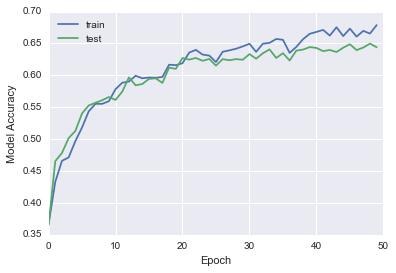

In [175]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

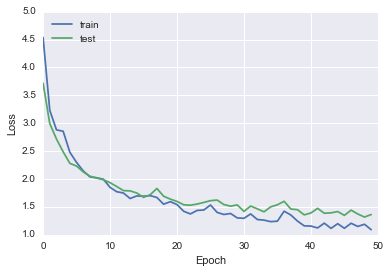

In [176]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [193]:
#125Hz 
# filtres sur 2 secondes so kernel_size =  250 (convolution windows of 2 seconds)

nb_filter1 = 20
kernel_size1 = 250

model = Sequential()
model.add(Conv1D(nb_filter=nb_filter1, kernel_size=kernel_size1, activation='relu', strides = 1, padding='valid', 
                 input_shape=X_train_r.shape[1:3]))

model.add(MaxPooling1D(25))
model.add(Conv1D(nb_filter=20, kernel_size=10, activation='relu', strides = 1, padding='valid'))
model.add(MaxPooling1D(10))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(5, activation='softmax'))

#optimizer = SGD(lr=0.0001)
#optimizer='rmsprop'
optimizer=Adam(0.0001)

model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train_r, y_train, batch_size=100, epochs=50, validation_data = (X_test_r, y_test))
score = model.evaluate(X_test_r, y_test, batch_size=100)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

#model.save('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\model_eeg_20_250.h5') 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=250, activation="relu", strides=1, padding="valid", input_shape=(3750, 4), filters=20)`
  if __name__ == '__main__':
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=10, activation="relu", strides=1, padding="valid", filters=20)`
  if sys.path[0] == '':


Train on 35064 samples, validate on 8766 samples
Epoch 1/50
35064/35064 [==============================] - 318s 9ms/step - loss: 5.0982 - acc: 0.3962 - val_loss: 3.5620 - val_acc: 0.4648
Epoch 2/50
35064/35064 [==============================] - 314s 9ms/step - loss: 3.3393 - acc: 0.4504 - val_loss: 3.0021 - val_acc: 0.4643
Epoch 3/50
35064/35064 [==============================] - 318s 9ms/step - loss: 3.1422 - acc: 0.4615 - val_loss: 2.9905 - val_acc: 0.4852
Epoch 4/50
35064/35064 [==============================] - 311s 9ms/step - loss: 2.6704 - acc: 0.4902 - val_loss: 2.6815 - val_acc: 0.4999
Epoch 5/50
35064/35064 [==============================] - 311s 9ms/step - loss: 2.6514 - acc: 0.4769 - val_loss: 2.5323 - val_acc: 0.4843
Epoch 6/50
35064/35064 [==============================] - 317s 9ms/step - loss: 2.5351 - acc: 0.4678 - val_loss: 2.3008 - val_acc: 0.5066
Epoch 7/50
35064/35064 [==============================] - 310s 9ms/step - loss: 2.2438 - acc: 0.4880 - val_loss: 2.2660 - v

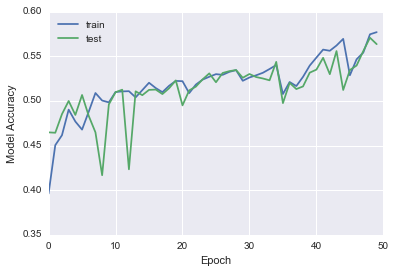

In [194]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

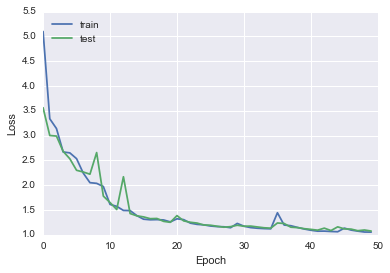

In [195]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

In [196]:
y_pred = pd.DataFrame(model.predict_classes(X_test_r, batch_size=128))
print("accurancy: ", accuracy_score(y_true, y_pred))
print("kappa: ", cohen_kappa_score(y_true, y_pred))

accurancy:  0.5635409536846908
kappa:  0.3941116562729232


In [199]:
#with dropout

nb_filter1 = 20
kernel_size1 = 50

model = Sequential()
model.add(Conv1D(nb_filter=nb_filter1, kernel_size=kernel_size1, activation='relu', strides = 1, padding='valid', 
                 input_shape=X_train_r.shape[1:3]))

model.add(MaxPooling1D(25))
model.add(Conv1D(nb_filter=20, kernel_size=10, activation='relu', strides = 1, padding='valid'))
model.add(MaxPooling1D(10))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(5, activation='softmax'))

#optimizer = SGD(lr=0.0001)
#optimizer='rmsprop'
optimizer=Adam(0.0001)

model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train_r, y_train, batch_size=100, epochs=50, validation_data = (X_test_r, y_test))
score = model.evaluate(X_test_r, y_test, batch_size=100)
print("Test score: ", score[0])
print("Test accuracy: ", score[1])

#model.save('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\model_eeg_20_250.h5') 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=50, activation="relu", strides=1, padding="valid", input_shape=(3750, 4), filters=20)`
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=10, activation="relu", strides=1, padding="valid", filters=20)`
  # This is added back by InteractiveShellApp.init_path()


Train on 35064 samples, validate on 8766 samples
Epoch 1/50
35064/35064 [==============================] - 150s 4ms/step - loss: 5.4919 - acc: 0.3901 - val_loss: 3.3501 - val_acc: 0.4512
Epoch 2/50
35064/35064 [==============================] - 148s 4ms/step - loss: 3.4459 - acc: 0.4386 - val_loss: 2.7143 - val_acc: 0.4946
Epoch 3/50
35064/35064 [==============================] - 151s 4ms/step - loss: 2.8537 - acc: 0.4599 - val_loss: 2.2812 - val_acc: 0.5196
Epoch 4/50
35064/35064 [==============================] - 149s 4ms/step - loss: 2.5451 - acc: 0.4804 - val_loss: 2.0658 - val_acc: 0.5240
Epoch 5/50
35064/35064 [==============================] - 146s 4ms/step - loss: 2.2601 - acc: 0.5016 - val_loss: 1.9028 - val_acc: 0.5416
Epoch 6/50
35064/35064 [==============================] - 146s 4ms/step - loss: 2.2416 - acc: 0.4796 - val_loss: 1.9589 - val_acc: 0.5201
Epoch 7/50
35064/35064 [==============================] - 146s 4ms/step - loss: 1.9691 - acc: 0.5097 - val_loss: 1.7240 - v

In [200]:
y_pred = pd.DataFrame(model.predict_classes(X_test_r, batch_size=128))
print("accurancy: ", accuracy_score(y_true, y_pred))
print("kappa: ", cohen_kappa_score(y_true, y_pred))

accurancy:  0.5206479580196213
kappa:  0.2507048379066573


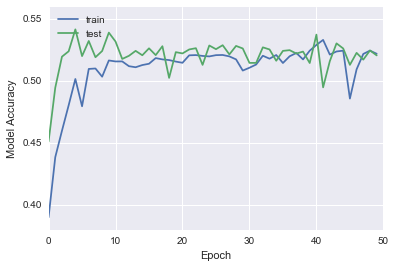

In [201]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

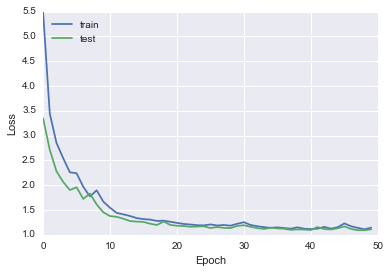

In [202]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')